### Discription
This notebook is inspired by the Reuters multiclass classification example from Deep Learning with Python by François Chollet and is implemented here for learning purposes with some additional explanations on the basis of my understanding.

# The Reuters dataset
Reuters dataset is a set of short newswires and their topics.There
are 46 different topics; some are more represented that the others but each topic has atleast 10 examples in the dataset



In [29]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # 0 = hide all, 1 = hide INFO, 2 = hide WARNING, 3 = hide ERROR
#The above piece of code is to hide the warnings 

## Loading the dataset:

In [30]:
from tensorflow.keras.datasets import reuters
(train_data,train_labels),(test_data,test_labels) = reuters.load_data(num_words=10000) #num_words=10000 restrics the data to 10000 most frequent words

print(train_data[0]) #sample train_data
print(train_labels[0]) #sample label
print(len(train_data)) #total number of training samples 
print(len(test_data)) #total number of testing samples 

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3
8982
2246


We have 8,982 training examples and 2,246 test examples to work with 

## Decoding a sample/ newswire back to text:

In [31]:
word_index = reuters.get_word_index() #returns dict mapping words to integers
reverse_word_index = dict(
    [(values,key) for (key,values) in word_index.items()]) #reversing the mapping to: from integers to words
decoded_newswire = " ".join(
    [reverse_word_index.get(i-3,'?') for i in train_data[0]]) #Note that the indices are offset by 3 because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown.”
print(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


## Preparing the data to feed into the model:
### Encoding the input data via multi-hot encoding:


In [32]:
import numpy as np
def vectorize_sequence(sequences,dimensions=10000):
    result = np.zeros(shape=(len(sequences),dimensions))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            result[i,j] = 1
    return result

X_train = vectorize_sequence(train_data)
X_test = vectorize_sequence(test_data)
print(X_train[0])

[0. 1. 1. ... 0. 0. 0.]


### Encoding the target labels via one-hot encoding:
One-hot encoding is a widely used format
for categorical data, also called categorical encoding.
Implementing it from scratch to get a good idea of how it works 

In [33]:
def one_hot_encode(labels,dimensions=46): #since we have a total of 46 classes of target variable dimensions=46
    result = np.zeros(shape=(len(labels),dimensions))
    for i, label in enumerate(labels):
        result[i,label] = 1
    return result

y_train = one_hot_encode(train_labels)
y_test = one_hot_encode(test_labels)
print(y_train[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


This can also be performed with a builtin method in keras called to_categorical

In [34]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)
print(y_train[0]) #result same as the above hardcoded one_hot_encode function

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Building model:
Just like binary classification problems here too we are trying to classify the texts. But a new cpnstraint has been introduced here that is the number of output classes has increased from 2 to 46. The dimensionality of the output class is much larger now.

16-dimensional space may be too limited to learn to separate 46 different classes,
such small layers may act as information bottlenecks, permanently dropping rele
vant information. For this reason we’ll use larger layers. Let’s go with 64 units.

In [35]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(46, activation='softmax')
])

* We end the model with a Dense layer of size 46. This means for each input
sample, the network will output a 46-dimensional vector. Each entry in this vector
(each dimension) will encode a different output class.
* The last layer uses a softmax activation. It means the model will output a probability distribution over the 46 different
output classes.
* For every input sample, the model will produce a 46-dimensional output vector, where output[i] is the probability that the sample belongs to class i.
* All the 46 scores in each output vector will add up to 1.

## Compilation step:
* As usual the optimizer being used will be 'rmsprop' which is default choice usually
* For loss_function we'll use 'categorical_crossentropy'
* Finally for metrics to  evaluate on we will be using 'accuracy'

In [36]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

## Vaidation set data:
Setting some data aside to validate the models performance during training on unseen data

In [37]:
X_val = X_train[:1000]
partial_x_train = X_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

## Training the model
Training the model on 20 epochs to see see the results on unseen validation data and then deciding at what epoch the model starts learning useless representations that dont help generalizaton and lead to overfitting 

In [38]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(X_val,y_val))

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.3866 - loss: 3.1408 - val_accuracy: 0.6300 - val_loss: 1.7545
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6812 - loss: 1.5686 - val_accuracy: 0.7170 - val_loss: 1.3363
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7446 - loss: 1.1808 - val_accuracy: 0.7380 - val_loss: 1.1661
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8070 - loss: 0.8896 - val_accuracy: 0.7620 - val_loss: 1.0539
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8443 - loss: 0.7560 - val_accuracy: 0.7960 - val_loss: 0.9709
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8728 - loss: 0.6136 - val_accuracy: 0.8110 - val_loss: 0.9150
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8982 - loss: 0.5015 - val_accuracy: 0.8160 - val_loss: 0.8744
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9124 - loss: 0.4264 - val_accuracy: 0.8170 - v

In [39]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


## Plotting graphs to compare training and validation accuracy as well as loss:

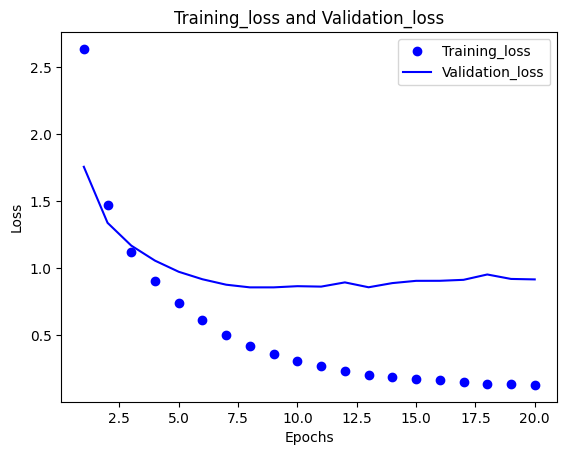

In [40]:
import matplotlib.pyplot as plt
#training_loss and validation_loss
training_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1,len(training_loss_values)+1)
plt.plot(epochs,training_loss_values,'bo',label='Training_loss') #'bo' stands for 'blue dot'
plt.plot(epochs,val_loss_values,'b',label='Validation_loss')
plt.title('Training_loss and Validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

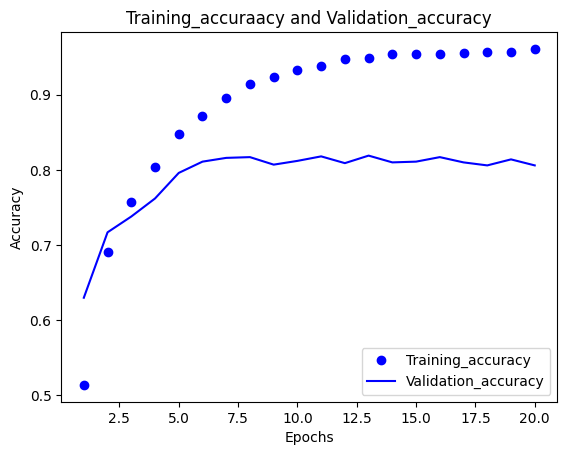

In [41]:
#training_accuracy and validation_accuracy
training_acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1,len(training_acc_values)+1)
plt.plot(epochs,training_acc_values,'bo',label='Training_accuracy') #'bo' stands for 'blue dot'
plt.plot(epochs,val_acc_values,'b',label='Validation_accuracy')
plt.title('Training_accuraacy and Validation_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The model starts to overfit after 9 epochs. Lets train a new model from scratch for 9 epochs and then evaluate on test set:

In [42]:
model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(46, activation='softmax')
])

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.fit(X_train,
         y_train,
         epochs=9,
         batch_size=512)
results = model.evaluate(X_test,y_test)
print(results)

Epoch 1/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3936 - loss: 3.1033
Epoch 2/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6764 - loss: 1.5246
Epoch 3/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7436 - loss: 1.1684
Epoch 4/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7967 - loss: 0.9388
Epoch 5/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8370 - loss: 0.7617
Epoch 6/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8668 - loss: 0.6210
Epoch 7/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8918 - loss: 0.5111
Epoch 8/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9027 - loss: 0.4505
Epoch 9/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9238 - loss: 0.3503
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7989 - loss: 0.8832
[0.9102290868759155, 0.7947462201118469]


The model reached an accuracy of ~80% on test data

## Generating predictions on unseen/test data:

In [43]:
predictions = model.predict(X_test)
#Each entry in prediction is a vector with 46 dimensions
print(predictions[0].shape)
#The largest entry is the predicted class—the class with the highest probability for each sample
y_pred1 = np.argmax(predictions[0])
print(y_pred1)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(46,)
4


## Key Takeaways:
* If we are trying to classify the samples into N classes, the final layer should be a Dense layer of N units.
* Unlike binary classificaion problem where we ended our network with a sigmoid, in casae of multiclass classification the final activation function should be softmax cuz it outputs distribution over N output classes.
* Categorical crossentropy calculates the distence between the probability distributions of output and the true distribution of the target.
* The targets of multiclass classification has to be encoded and that can be done in two ways:
  1. Encoding the labels via categorical encoding/ one-hot and using categorical_crossentropy as loss function.
  2. Encoding the labels as integers and using sparse_categorical_crossentropy loss function.
* Creating information bottlenecks can lead to loss of information due to intermediate layers that are too small.